In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model, models, layers, mixed_precision
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, Flatten, Dense, Reshape, Conv2DTranspose, Activation, Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D, Conv1DTranspose
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from sklearn import preprocessing
from keras import backend as K
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
import json
import sys, os, pickle, numpy as np, pandas as pd

# import autoencoder

from kapre import STFT, Magnitude, MagnitudeToDecibel
from kapre.composed import get_melspectrogram_layer, get_log_frequency_spectrogram_layer


2022-07-16 08:20:36.967442: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [5]:
import json
from collections import namedtuple
from json import JSONEncoder

def customJSONDecoder(JSONDict):
    return namedtuple('Namespace', JSONDict.keys())(*JSONDict.values())

config = json.load(open('./autoencoder_config.json'), object_hook=customJSONDecoder)
print(config)


Namespace(data_path='../../datasets/denoising', lr=5e-05, epochs=5, batch=16, log_step=10, multi_gpu=False, gpu=2, suffix='denoising_AE')


# 1D Autoencoder model for denoising

In [ ]:
# from tqdm import tqdm
# import librosa
# path='../../datasets/gtzan10sAug/datasets/snr5Full/audio/cleanAudio'
# output_path = '../../datasets/denoising/clean'

# dirName, splits, _ = next(os.walk(path))
# # print(splits)
# for split in splits:
#     print(split)
#     if not os.path.exists(os.path.join(output_path,split)):
#         print("Creating output directory for: ", split)
#         os.makedirs(os.path.join(output_path,split))
#     _,subdirs,_ = next(os.walk(os.path.join(path, split)))
#     for subdir in subdirs:
#         print(subdir)
#         _,_,filelist = next(os.walk(os.path.join(path, split, subdir)))
#         for f in filelist:
#             fname = f[:-4]
#             x,sr = librosa.load(os.path.join(path, split, subdir, f))
#             np.save(os.path.join(output_path, split,f'{fname}.npy'),x)

In [15]:
class AudioLoader(keras.utils.Sequence):
    def __init__(self, mode, batch_size):
        self.batch_size = batch_size
        self.mode = mode
        self.pos = np.random.randint(0,220500-66150)
        np.random.seed(42)

        self.clean_suffix = 'clean'
        self.augmented_suffix = 'augmented'


        if self.mode == 'train': 
            self.noisy_path = os.path.join(config.data_path, self.augmented_suffix,'train')
            self.clean_path = os.path.join(config.data_path, self.clean_suffix,'train')
        if self.mode == 'test':
            self.noisy_path = os.path.join(config.data_path, self.augmented_suffix,'test')
            self.clean_path = os.path.join(config.data_path, self.clean_suffix,'test')
        if self.mode == 'val':
            self.noisy_path = os.path.join(config.data_path, self.augmented_suffix,'val')
            self.clean_path = os.path.join(config.data_path, self.clean_suffix,'val')
        # print(os.path.exists(self.data_path))
        _,_,self.filenames = next(os.walk(self.noisy_path))

    def __len__(self):
        return int(len(self.filenames) // self.batch_size)

    def __getitem__(self,idx):
        try:
            source = np.empty((self.batch_size, 220500))#66150))#220500))
            target = np.empty((self.batch_size, 220500))#66150))#220500))
            batch = self.filenames[idx * self.batch_size : (idx+1) * self.batch_size]
            for i, ID in enumerate(batch):
                tmp = np.load(os.path.join(self.noisy_path, ID), allow_pickle=True)
                source[i] = tmp[0]#[self.pos:self.pos+660150]
                tmp2 = np.load(os.path.join(self.clean_path, f'{ID.split("_")[0]}.npy'), allow_pickle=True)
                target[i] = tmp2[0]#[self.pos:self.pos+660150]
            return source,target#X,y #bat[:,0], bat[:,1]
        except Exception as e:
            print(i, ID)
            print(e)


In [16]:
train = AudioLoader('train', 32)
val = AudioLoader('val',32)
test = AudioLoader('test', 32)
config = json.load(open('./autoencoder_config.json'), object_hook=customJSONDecoder)

In [22]:
np.load(os.path.join(train.noisy_path,train.filenames[0]))

-0.11665034

In [17]:
next(iter(train))

(array([[-0.11665034, -0.11665034, -0.11665034, ..., -0.11665034,
         -0.11665034, -0.11665034],
        [-0.14452517, -0.14452517, -0.14452517, ..., -0.14452517,
         -0.14452517, -0.14452517],
        [ 0.11407971,  0.11407971,  0.11407971, ...,  0.11407971,
          0.11407971,  0.11407971],
        ...,
        [-0.02606082, -0.02606082, -0.02606082, ..., -0.02606082,
         -0.02606082, -0.02606082],
        [ 0.01890647,  0.01890647,  0.01890647, ...,  0.01890647,
          0.01890647,  0.01890647],
        [ 0.02381718,  0.02381718,  0.02381718, ...,  0.02381718,
          0.02381718,  0.02381718]]),
 array([[ 0.07775879,  0.07775879,  0.07775879, ...,  0.07775879,
          0.07775879,  0.07775879],
        [-0.0295105 , -0.0295105 , -0.0295105 , ..., -0.0295105 ,
         -0.0295105 , -0.0295105 ],
        [ 0.02835083,  0.02835083,  0.02835083, ...,  0.02835083,
          0.02835083,  0.02835083],
        ...,
        [-0.10968018, -0.10968018, -0.10968018, ..., -

In [186]:
# # STACKOVERFLOW EXAMPLE

# input_sig = Input(batch_shape=(1,128,1))
# x = Conv1D(8,3, activation='relu', padding='same',dilation_rate=2)(input_sig)
# x1 = MaxPooling1D(2)(x)
# x2 = Conv1D(4,3, activation='relu', padding='same',dilation_rate=2)(x1)
# x3 = MaxPooling1D(2)(x2)
# x4 = AveragePooling1D()(x3)
# flat = Flatten()(x4)
# encoded = Dense(2)(flat)
# d1 = Dense(64)(encoded)
# d2 = Reshape((16,4))(d1)
# d3 = Conv1D(4,1,strides=1, activation='relu', padding='same')(d2)
# d4 = UpSampling1D(2)(d3)
# d5 = Conv1D(8,1,strides=1, activation='relu', padding='same')(d4)
# d6 = UpSampling1D(2)(d5)
# d7 = UpSampling1D(2)(d6)
# decoded = Conv1D(1,1,strides=1, activation='sigmoid', padding='same')(d7)
# model= Model(input_sig, decoded)

In [ ]:
def get_model(layers):
    if layers == 1:
        input_sig = Input(batch_shape=(32,220500,1))
        x = Conv1D(32,2048, activation='relu', padding='same')(input_sig)
        d3 = Conv1DTranspose(32,2048,activation='relu', padding='same')(x)
        decoded = Conv1D(1,1,strides=1, activation='sigmoid', padding='same')(d3)
        model= Model(input_sig, decoded)
    if layers == 3:
        input_sig = Input(batch_shape=(32,220500,1))
        # ENCODER
        x1 = Conv1D(128,2048, activation='relu', padding='same')(input_sig)
        x2 = Conv1D(64,2048, activation='relu',padding='same')(x1)
        x3 = Conv1D(32,2048, activation='relu',padding='same')(x2)
        # BOTTLENECK
        B = Dense(24)(x3)
        # DECODER
        d1 = Conv1DTranspose(32,2048, activation='relu',padding='same')(B)
        d2 = Conv1DTranspose(64, 2048, activation='relu',padding='same')(d1)
        d3 = Conv1DTranspose(128,2048,activation='relu', padding='same')(d2)
        # OUTPUT LAYER
        decoded = Conv1D(1,1,strides=1, activation='sigmoid', padding='same')(d3)
        model= Model(input_sig, decoded)
    

    print(model.summary())
    return model

In [2]:
input_sig = Input(batch_shape=(32,220500,1))
# ENCODER
x1 = Conv1D(128,2048, activation='relu', padding='same')(input_sig)
x2 = Conv1D(64,1024, activation='relu',padding='same')(x1)
x3 = Conv1D(32,512, activation='relu',padding='same')(x2)
# BOTTLENECK
B = Dense(24)(x3)
# DECODER
d1 = Conv1DTranspose(32,512, activation='relu',padding='same')(B)
d2 = Conv1DTranspose(64, 1024, activation='relu',padding='same')(d1)
d3 = Conv1DTranspose(128,2048,activation='relu', padding='same')(d2)
# OUTPUT LAYER
decoded = Conv1D(1,1,strides=1, activation='sigmoid', padding='same')(d3)
model= Model(input_sig, decoded)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(32, 220500, 1)]         0         
                                                                 
 conv1d (Conv1D)             (32, 220500, 128)         262272    
                                                                 
 conv1d_1 (Conv1D)           (32, 220500, 64)          8388672   
                                                                 
 conv1d_2 (Conv1D)           (32, 220500, 32)          1048608   
                                                                 
 dense (Dense)               (32, 220500, 24)          792       
                                                                 
 conv1d_transpose (Conv1DTra  (32, 220500, 32)         393248    
 nspose)                                                         
                                                             

2022-07-16 07:59:59.152011: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-16 08:00:00.470042: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9650 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5
2022-07-16 08:00:00.470944: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9650 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:18:00.0, compute capability: 7.5
2022-07-16 08:00:00.471708: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:loc

: 

In [191]:
# bottleneck_dim = 16

# input_sig = Input(batch_shape=(32,220500,1))
# x = Conv1D(32,2048, strides=1024, activation='relu', padding='same')(input_sig)
# # x1 = MaxPooling1D(2)(x)
# # x2 = Conv1D(4,3, activation='relu', padding='same',dilation_rate=2)(x1)
# # x3 = MaxPooling1D(2)(x2)
# # x4 = AveragePooling1D()(x3)
# # flat = Flatten()(x)
# # encoded = Dense(bottleneck_dim)(flat)
# # d1 = Dense(bottleneck_dim)(encoded)
# # d2 = Reshape((16,4))(d1)
# d3 = Conv1DTranspose(32,2048,strides=1024, activation='relu', padding='same')(x)#(d2)
# # d4 = UpSampling1D(256)(d3)
# # d5 = Conv1D(8,1,strides=1, activation='relu', padding='same')(d4)
# # d6 = UpSampling1D(2)(d5)
# # d7 = UpSampling1D(2)(d6)
# decoded = Conv1D(1,1,strides=1, activation='sigmoid', padding='same')(d3)
# model= Model(input_sig, decoded)
# model.summary()

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(32, 220500, 1)]         0         
                                                                 
 conv1d_95 (Conv1D)          (32, 216, 32)             65568     
                                                                 
 conv1d_transpose_1 (Conv1DT  (32, 222208, 32)         2097184   
 ranspose)                                                       
                                                                 
 conv1d_96 (Conv1D)          (32, 222208, 1)           33        
                                                                 
Total params: 2,162,785
Trainable params: 2,162,785
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config.lr), loss=tf.keras.losses.MeanSquaredError())
history = model.fit(train, validation_data=val, epochs=config.epochs)
model.evaluate(test)

Epoch 1/14


2022-07-15 09:17:14.741752: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


 3/41 [=>............................] - ETA: 19:31 - loss: 0.1958

KeyboardInterrupt: 

: 

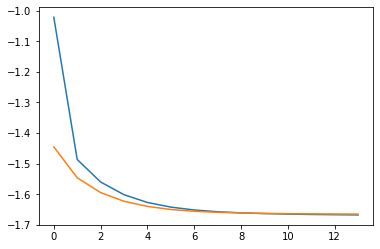

In [162]:
plt.figure()
plt.plot(np.log10(history.history['loss']))
plt.plot(np.log10(history.history['val_loss']))
plt.show()

In [121]:
df=pd.DataFrame(history.history)
df

,loss,val_loss
0,0.104210,0.040097
1,0.035733,0.030683
2,0.029753,0.027166
3,0.026775,0.025124
4,0.024940,0.023876
5,0.023755,0.023086
6,0.023001,0.022584
7,0.022520,0.022248
8,0.022186,0.022057
9,0.021977,0.021917


In [175]:
cleaned = model.predict(test)

27/27 [==============================] - 2s 80ms/step


In [167]:
len(test)*32

864

In [165]:
cleaned.shape

(864, 1, 1)

In [169]:
model(test)

AttributeError: 'AudioLoader' object has no attribute 'to_tensor'

In [180]:
test_file = np.load('../../datasets/denoising/augmented/test/blues.00012.0_street_traffic-prague-1153-42960-a_h146_Outside_MITCampus_1txts.npy')
input_tensor = np.expand_dims(test_file, axis=0)
cleaned = model.predict(input_tensor)
# import soundfile as sf
# sf.write('denoised_file.wav', cleaned, 22050)

1/1 [==============================] - 0s 22ms/step


In [181]:
cleaned

array([[[0.00559153]]], dtype=float32)

In [3]:
model = tf.keras.models.load_model('../models/denoising_AE')

2022-07-16 04:38:43.361217: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-16 04:38:44.694218: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9650 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5
2022-07-16 04:38:44.695098: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9650 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:18:00.0, compute capability: 7.5
2022-07-16 04:38:44.695848: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:loc

In [5]:
test_file = np.load('../../datasets/denoising/augmented/test/blues.00012.0_street_traffic-prague-1153-42960-a_h146_Outside_MITCampus_1txts.npy')
input_tensor = np.expand_dims(test_file, axis=0)
x = model(input_tensor)

In [6]:
x.shape

TensorShape([1, 220500, 1])

In [20]:
import soundfile as sf
sf.write('denoised_file.wav', np.squeeze(x.numpy()), 22050)
